In [2]:
# importing the libraries
import numpy as np
import peakutils
import syntheticdata
import threegaussians
import lorentzian
from peakutils.plot import plot as pplot
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from scipy import interpolate
from astropy.modeling import models, fitting
import pandas as pd

In [3]:
def Earth_Peakutils(nm_array, timedelay,threshold,min_dist):
    import numpy
    import matplotlib.pyplot as plt
    from pyearth import Earth
    
    """
     ============================================
     Plotting derivatives of simple sine function
    ============================================

     A simple example plotting a fit of the sine function
    and the derivatives computed by Earth.
    
    Notes
    -----   
    generates a denoise curve from the TA data
    Parameters
    ----------
        nm_array: wavelength array
        timedelay: time delay array
        noise_coefficient: the noise coefficients that user want to generate
    Returns
    -------
        a smoothing curve from the original noise curve   
    """
    # Create some fake data
    # generate some noisy data from syntheticdata:
    np.random.seed(1729)
    y_noise = 0.1 * np.random.normal(size=nm_array.size)
    ydata = timedelay + y_noise
    
   # Fit an Earth model
    model = Earth(max_degree=2, minspan_alpha=.5, smooth=True)
    model.fit(nm_array, ydata)
    
   # Get the predicted values and derivatives
    y_hat = model.predict(nm_array)
   
    # use peakutils to find peak indexs
    peak_indices_true = peakutils.indexes(timedelay, thres=threshold, min_dist=min_dist)
    peak_indices_smooth = peakutils.indexes(y_hat, thres=threshold, min_dist=min_dist)
    
    return peak_indices_true,peak_indices_smooth
    

In [4]:
def astropy_Peakutils(nm_array,timedelay,gg_init,threshold,min_dist):
    # Generate fake data
    np.random.seed(42)
    ydata = timedelay + 0.1*np.random.normal(size=nm_array.size)
    # Now to fit the data create a new superposition with initial
    # guesses for the parameters:
    fitter = fitting.SLSQPLSQFitter()
    gg_fit = fitter(gg_init, nm_array, ydata)
    # use peakutils to find peak
    peak_indices_true = peakutils.indexes(timedelay, thres=threshold, min_dist=min_dist)
    peak_indices_smooth = peakutils.indexes(gg_fit(nm_array), thres=threshold, min_dist=min_dist)
  
    return peak_indices_true,peak_indices_smooth

In [5]:
def astropy_Smoothing(nm_array,timedelay,noise_coefficient,gg_init):
    # Generate fake data
    np.random.seed(42)
    ydata = timedelay + noise_coefficient*np.random.normal(size=nm_array.size)
    # Now to fit the data create a new superposition with initial
    # guesses for the parameters:
    fitter = fitting.SLSQPLSQFitter()
    gg_fit = fitter(gg_init, nm_array, ydata)
  
    return gg_fit(nm_array)

In [6]:
def Earth_Smoothing(nm_array, y_array,noise_coefficient):        
    """
    ============================================
     Plotting derivatives of simple sine function
    ============================================

     A simple example plotting a fit of the sine function
    and the derivatives computed by Earth.
    
    Notes
    -----   
    generates a denoise curve from the TA data
    Parameters
    ----------
        nm_array: wavelength array
        timedelay: time delay array
        noise_coefficient: the noise coefficients that user want to generate
    Returns
    -------
        a smoothing curve from the original noise curve   
    """
    from pyearth import Earth
   # Fit an Earth model
    model = Earth(smooth=True)
    np.random.seed(42)
    ydata = y_array + noise_coefficient*np.random.normal(size=nm_array.size)
    model.fit(nm_array, ydata)

   # Print the model
    #print(model.trace())
    #print(model.summary())

   # Get the predicted values and derivatives
    y_hat = model.predict(nm_array)
    
    return  y_hat

# Get noise data and smoothing data dataframe

* astropy

In [7]:
def astropy_smooth_matrix(nm_array,data_matrix,noise_coefficient,gg_init):
    num_array = np.shape(data_matrix)[0]
    
    smooth_matx = pd.DataFrame(np.empty((num_array,1)), columns = ['a'])
    noise_matx = pd.DataFrame(np.empty((num_array,1)), columns = ['a'])
    
    for i in range(num_array):
        data_array = data_matrix[:, i]
        
        # get noise and smooth list
        noise_array = add_noise(nm_array, data_array, noise_coefficient).tolist()
        smooth_array = astropy_Smoothing(nm_array,data_array,noise_coefficient,gg_init).tolist()
        
        # get noise dataframe
        DF = pd.DataFrame(noise_array,columns = [i])
        noise_matx = noise_matx.join(DF)
        
        # get smooth dataframe
        df = pd.DataFrame(smooth_array,columns = [i])
        smooth_matx = smooth_matx.join(df)
        
    # drop the first columns  
    noise_matx = noise_matx.drop(columns='a')
    smooth_matx = smooth_matx.drop(columns='a')
        
    return noise_matx, smooth_matx

In [32]:
noise_matx, smooth_matx = astropy_smooth_matrix(datanm,dataz_matx,0.1,gg_init)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7495624261835365
            Iterations: 35
            Function evaluations: 286
            Gradient evaluations: 35
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749416520979112
            Iterations: 26
            Function evaluations: 213
            Gradient evaluations: 26
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7494332869998
            Iterations: 35
            Function evaluations: 286
            Gradient evaluations: 35
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749375198644923
            Iterations: 36
            Function evaluations: 293
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749431472355961
            Iterations: 36
            Function 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749372368287485
            Iterations: 36
            Function evaluations: 294
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7494020076627805
            Iterations: 37
            Function evaluations: 301
            Gradient evaluations: 37
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749120629652938
            Iterations: 37
            Function evaluations: 301
            Gradient evaluations: 37
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749316680378654
            Iterations: 38
            Function evaluations: 309
            Gradient evaluations: 38
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749372267100967
            Iterations: 38
            Functio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748982964647777
            Iterations: 42
            Function evaluations: 341
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749130093999115
            Iterations: 42
            Function evaluations: 341
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749289068725178
            Iterations: 42
            Function evaluations: 341
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749215960027268
            Iterations: 42
            Function evaluations: 341
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7491290293996045
            Iterations: 42
            Functio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748782798182194
            Iterations: 45
            Function evaluations: 365
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748754145004412
            Iterations: 45
            Function evaluations: 365
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748900892926467
            Iterations: 45
            Function evaluations: 365
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748801029238395
            Iterations: 45
            Function evaluations: 365
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748746895082606
            Iterations: 45
            Function

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748194345699799
            Iterations: 40
            Function evaluations: 325
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.74832111065758
            Iterations: 43
            Function evaluations: 349
            Gradient evaluations: 43
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748252099354339
            Iterations: 43
            Function evaluations: 349
            Gradient evaluations: 43
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.74820392696251
            Iterations: 42
            Function evaluations: 341
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748257131080866
            Iterations: 43
            Function e

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7475736323967626
            Iterations: 45
            Function evaluations: 365
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.747478833351527
            Iterations: 49
            Function evaluations: 397
            Gradient evaluations: 49
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.74753339253865
            Iterations: 45
            Function evaluations: 365
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7473897525888535
            Iterations: 45
            Function evaluations: 365
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.747363785054652
            Iterations: 49
            Functio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.747117121925669
            Iterations: 49
            Function evaluations: 398
            Gradient evaluations: 49
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.747102761675739
            Iterations: 49
            Function evaluations: 398
            Gradient evaluations: 49
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7512856370174745
            Iterations: 38
            Function evaluations: 310
            Gradient evaluations: 38
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.747392746246069
            Iterations: 54
            Function evaluations: 437
            Gradient evaluations: 54
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.74718397002313
            Iterations: 54
            Function

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.753073885496827
            Iterations: 41
            Function evaluations: 335
            Gradient evaluations: 41
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.753115752745154
            Iterations: 41
            Function evaluations: 335
            Gradient evaluations: 41
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748707388234957
            Iterations: 56
            Function evaluations: 456
            Gradient evaluations: 56
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748767697070375
            Iterations: 57
            Function evaluations: 462
            Gradient evaluations: 57
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7487205795910725
            Iterations: 56
            Functio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.75551338043862
            Iterations: 45
            Function evaluations: 365
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7556611827891935
            Iterations: 45
            Function evaluations: 365
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.755724212414469
            Iterations: 47
            Function evaluations: 382
            Gradient evaluations: 47
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.755840220095371
            Iterations: 46
            Function evaluations: 374
            Gradient evaluations: 46
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.755814705337782
            Iterations: 45
            Function

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773318663207655
            Iterations: 31
            Function evaluations: 255
            Gradient evaluations: 31
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773146310854472
            Iterations: 30
            Function evaluations: 245
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773147992252777
            Iterations: 31
            Function evaluations: 253
            Gradient evaluations: 31
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773329489650065
            Iterations: 33
            Function evaluations: 269
            Gradient evaluations: 33
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773165324260232
            Iterations: 31
            Function

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773681707468513
            Iterations: 32
            Function evaluations: 264
            Gradient evaluations: 32
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773816475474296
            Iterations: 33
            Function evaluations: 272
            Gradient evaluations: 33
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773783293994764
            Iterations: 31
            Function evaluations: 256
            Gradient evaluations: 31
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773840196975427
            Iterations: 31
            Function evaluations: 255
            Gradient evaluations: 31
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7737964928605106
            Iterations: 31
            Functio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774284561574538
            Iterations: 32
            Function evaluations: 263
            Gradient evaluations: 32
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774356732235045
            Iterations: 31
            Function evaluations: 255
            Gradient evaluations: 31
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774407306811416
            Iterations: 32
            Function evaluations: 266
            Gradient evaluations: 32
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774465312610029
            Iterations: 34
            Function evaluations: 279
            Gradient evaluations: 34
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774384021895722
            Iterations: 33
            Function

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774820424037973
            Iterations: 36
            Function evaluations: 300
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774826078750889
            Iterations: 35
            Function evaluations: 290
            Gradient evaluations: 35
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774841925358913
            Iterations: 35
            Function evaluations: 292
            Gradient evaluations: 35
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774845225488919
            Iterations: 35
            Function evaluations: 291
            Gradient evaluations: 35
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774851504280549
            Iterations: 36
            Function

IndexError: index 500 is out of bounds for axis 1 with size 500

* py-earth

In [34]:
def earth_smooth_matrix(nm_array,data_matrix,noise_coefficient):
    num_array = np.shape(data_matrix)[0]
    
    smooth_matx = pd.DataFrame(np.empty((num_array,1)), columns = ['a'])
    noise_matx = pd.DataFrame(np.empty((num_array,1)), columns = ['a'])
    
    for i in range(500):
        data_array = data_matrix[:, i]
        
        # get noise and smooth list
        noise_array = add_noise(nm_array, data_array, noise_coefficient).tolist()
        smooth_array = Earth_Smoothing(nm_array,data_array,noise_coefficient).tolist()
        
        # get noise dataframe
        DF = pd.DataFrame(noise_array,columns = [i])
        noise_matx = noise_matx.join(DF)
        
        # get smooth dataframe
        df = pd.DataFrame(smooth_array,columns = [i])
        smooth_matx = smooth_matx.join(df)
        
    # drop the first columns  
    noise_matx = noise_matx.drop(columns='a')
    smooth_matx = smooth_matx.drop(columns='a')
        
    return noise_matx, smooth_matx

In [35]:
noisez_matx, smooth_matx = earth_smooth_matrix(datanm,dataz_matx,0.1)

/usr/local/lib/python3.5/dist-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/usr/local/lib/python3.5/dist-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [36]:
noisez_matx

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.642958,0.637558,0.632158,0.626758,0.621458,0.616158,0.610958,0.605758,0.600558,0.595458,...,0.037439,0.037421,0.037403,0.037385,0.037368,0.037351,0.037335,0.037318,0.037302,0.037286
1,0.750254,0.744754,0.739254,0.733854,0.728454,0.723154,0.717754,0.712554,0.707354,0.702154,...,0.132600,0.132581,0.132563,0.132544,0.132526,0.132508,0.132490,0.132473,0.132456,0.132440
2,0.516295,0.510695,0.505195,0.499695,0.494295,0.488895,0.483495,0.478195,0.472895,0.467695,...,-0.113389,-0.113410,-0.113429,-0.113449,-0.113468,-0.113487,-0.113505,-0.113524,-0.113542,-0.113559
3,0.594156,0.588556,0.582956,0.577456,0.571956,0.566456,0.561056,0.555656,0.550356,0.545056,...,-0.047556,-0.047577,-0.047598,-0.047618,-0.047638,-0.047658,-0.047678,-0.047697,-0.047716,-0.047735
4,0.727119,0.721419,0.715819,0.710219,0.704619,0.699119,0.693619,0.688219,0.682819,0.677419,...,0.073384,0.073362,0.073340,0.073318,0.073297,0.073276,0.073255,0.073235,0.073214,0.073195
5,0.660581,0.654881,0.649181,0.643581,0.637981,0.632381,0.626881,0.621381,0.615881,0.610481,...,-0.005073,-0.005097,-0.005120,-0.005143,-0.005165,-0.005188,-0.005209,-0.005231,-0.005252,-0.005273
6,0.863220,0.857420,0.851720,0.846020,0.840320,0.834720,0.829220,0.823620,0.818120,0.812620,...,0.185650,0.185626,0.185601,0.185577,0.185553,0.185530,0.185507,0.185484,0.185462,0.185440
7,0.703915,0.698115,0.692315,0.686615,0.680915,0.675215,0.669615,0.664015,0.658515,0.652915,...,0.014535,0.014508,0.014483,0.014457,0.014432,0.014408,0.014383,0.014360,0.014336,0.014313
8,0.871805,0.865905,0.860105,0.854305,0.848605,0.842805,0.837205,0.831505,0.825905,0.820405,...,0.170618,0.170591,0.170564,0.170537,0.170511,0.170485,0.170459,0.170434,0.170409,0.170385
9,0.807060,0.801160,0.795360,0.789460,0.783760,0.777960,0.772260,0.766560,0.760960,0.755360,...,0.094271,0.094243,0.094214,0.094186,0.094158,0.094131,0.094104,0.094078,0.094052,0.094026


In [37]:
smooth_matx

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.645373,0.639381,0.633468,0.627576,0.611674,0.618547,0.611966,0.634780,0.606053,0.601244,...,0.016305,-0.010655,-0.023073,-0.031775,0.067144,0.066869,-0.011714,0.067293,-0.019757,-0.016914
1,0.653034,0.647048,0.641138,0.635249,0.619956,0.626084,0.619535,0.640981,0.613364,0.608437,...,0.012922,-0.011706,-0.023073,-0.030959,0.059900,0.059681,-0.012675,0.059804,-0.019157,-0.016342
2,0.660695,0.654715,0.648808,0.642922,0.628238,0.633620,0.627105,0.647182,0.620675,0.615629,...,0.009539,-0.012756,-0.023073,-0.030143,0.052657,0.052494,-0.013637,0.052315,-0.018556,-0.015771
3,0.668357,0.662381,0.656478,0.650595,0.636520,0.641157,0.634674,0.653383,0.627986,0.622822,...,0.006156,-0.013806,-0.023073,-0.029326,0.045413,0.045306,-0.014598,0.044826,-0.017956,-0.015200
4,0.676018,0.670048,0.664147,0.658268,0.644803,0.648694,0.642243,0.659583,0.635297,0.630015,...,0.002774,-0.014856,-0.023073,-0.028510,0.038169,0.038119,-0.015560,0.037337,-0.017355,-0.014628
5,0.683680,0.677715,0.671817,0.665941,0.653085,0.656230,0.649813,0.665784,0.642608,0.637208,...,-0.000609,-0.015906,-0.023073,-0.027694,0.030925,0.030931,-0.016521,0.029848,-0.016754,-0.014057
6,0.691341,0.685382,0.679487,0.673614,0.661367,0.663767,0.657382,0.671985,0.649919,0.644400,...,-0.003992,-0.016956,-0.023073,-0.026878,0.023682,0.023744,-0.017483,0.022359,-0.016154,-0.013486
7,0.699003,0.693049,0.687157,0.681287,0.669649,0.671303,0.664952,0.678186,0.657230,0.651593,...,-0.007375,-0.018006,-0.023073,-0.026062,0.016438,0.016557,-0.018444,0.014870,-0.015553,-0.012915
8,0.706664,0.700716,0.694827,0.688960,0.677931,0.678840,0.672521,0.684387,0.664541,0.658786,...,-0.010783,-0.019068,-0.023078,-0.025246,0.009145,0.009321,-0.019417,0.007381,-0.014953,-0.012343
9,0.714326,0.708382,0.702496,0.696633,0.686213,0.686377,0.680090,0.690588,0.671852,0.665978,...,-0.014175,-0.020122,-0.023080,-0.024430,0.001885,0.002117,-0.020382,-0.000108,-0.014352,-0.011772


# -------------------------------------------------------------------------------------------
# * Get peak dataframe

In [38]:
# load some data
def loaddata(data_filename):
    """load matrix data"""
    data = np.genfromtxt(data_filename, delimiter='\t')
    data_nm = data[1:,0]    #wavelength in nm
    data_time = data[0,1:]
    data_z = data[1:, 1:]

    return data_nm, data_time, data_z

In [39]:
# add noise
def add_noise(nm_array, y_array, noise_coefficient):
    # Add noise
    np.random.seed(1800)
    y_noise = noise_coefficient * np.random.normal(size=nm_array.size)
    y_proc = y_array + y_noise
    
    return y_proc

In [40]:
def astropy_smoothing(nm_array, timedelay, noise_coefficient,gg_init):
    # Generate fake data
    np.random.seed(42)
    ydata = timedelay + noise_coefficient*np.random.normal(size=nm_array.size)
    # Now to fit the data create a new superposition with initial
    # guesses for the parameters:
    fitter = fitting.SLSQPLSQFitter()
    gg_fit = fitter(gg_init, nm_array, ydata)
    return gg_fit(nm_array)

## astropy and peakutils 

In [41]:
def astropy_peak_matrix(nm_array,data_matrix,noise_coefficient,threshold, min_dist,gg_init):
    num_array = np.shape(data_matrix)[1]
    true_peak = []
    smooth_peak = []
    
    for i in range(num_array):
        data_array = data_matrix[:, i]
        noise_array = add_noise(nm_array, data_array, noise_coefficient)
        smooth_array = astropy_smoothing(nm_array, data_array,noise_coefficient,gg_init)
        
        # get true peak matrix
        indexes=findpeak(data_array, threshold, min_dist).tolist()
        true_peak.append(indexes)
        #get smooth peak matrix
        
        indexes1=findpeak(smooth_array, threshold, min_dist).tolist()
        smooth_peak.append(indexes1)
        
        # transfer to dataframe
        true_df=pd.DataFrame(true_peak)
        smooth_df=pd.DataFrame(smooth_peak)
    
    return true_df, smooth_df

In [42]:
def findpeak(data_z_array, threshold, min_dist):
    """find peaks and return indices of the peaks"""    
    peak_indices = peakutils.indexes(data_z_array, thres=threshold, min_dist=min_dist)
    
    return peak_indices

In [43]:
matx_filename = '20180418_twogaussian_spectralshfit.txt'
datanm, datatime, dataz_matx = loaddata(matx_filename)
g1 = models.Gaussian1D(1, 950, 30)
g2 = models.Gaussian1D(0.3, 1300, 100)
gg_init = g1+g2

In [18]:
# get the peak position dataframe of smooth data set
true_df1, smooth_df1 = astropy_peak_matrix(datanm, dataz_matx, 0.1, 0, 10,gg_init)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7495624261835365
            Iterations: 35
            Function evaluations: 286
            Gradient evaluations: 35
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749416520979112
            Iterations: 26
            Function evaluations: 213
            Gradient evaluations: 26
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7494332869998
            Iterations: 35
            Function evaluations: 286
            Gradient evaluations: 35
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749375198644923
            Iterations: 36
            Function evaluations: 293
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749431472355961
            Iterations: 36
            Function 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749372558471001
            Iterations: 36
            Function evaluations: 293
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749372368287485
            Iterations: 36
            Function evaluations: 294
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7494020076627805
            Iterations: 37
            Function evaluations: 301
            Gradient evaluations: 37
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749120629652938
            Iterations: 37
            Function evaluations: 301
            Gradient evaluations: 37
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749316680378654
            Iterations: 38
            Functio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749181534395437
            Iterations: 41
            Function evaluations: 333
            Gradient evaluations: 41
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.74909389975479
            Iterations: 41
            Function evaluations: 333
            Gradient evaluations: 41
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748982964647777
            Iterations: 42
            Function evaluations: 341
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749130093999115
            Iterations: 42
            Function evaluations: 341
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.749289068725178
            Iterations: 42
            Function 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.74888844192722
            Iterations: 45
            Function evaluations: 365
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.74879976179185
            Iterations: 45
            Function evaluations: 365
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748782798182194
            Iterations: 45
            Function evaluations: 365
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748754145004412
            Iterations: 45
            Function evaluations: 365
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748900892926467
            Iterations: 45
            Function e

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748337115588772
            Iterations: 45
            Function evaluations: 365
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748210239120597
            Iterations: 43
            Function evaluations: 349
            Gradient evaluations: 43
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748194345699799
            Iterations: 40
            Function evaluations: 325
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.74832111065758
            Iterations: 43
            Function evaluations: 349
            Gradient evaluations: 43
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748252099354339
            Iterations: 43
            Function 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.747426959566901
            Iterations: 47
            Function evaluations: 381
            Gradient evaluations: 47
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.747541288579951
            Iterations: 45
            Function evaluations: 365
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.747526753270345
            Iterations: 45
            Function evaluations: 365
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7475736323967626
            Iterations: 45
            Function evaluations: 365
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.747478833351527
            Iterations: 49
            Functio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.747121162495429
            Iterations: 53
            Function evaluations: 430
            Gradient evaluations: 53
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.747045021356566
            Iterations: 50
            Function evaluations: 407
            Gradient evaluations: 50
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.74711401180571
            Iterations: 51
            Function evaluations: 415
            Gradient evaluations: 51
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7471956789396685
            Iterations: 51
            Function evaluations: 414
            Gradient evaluations: 51
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.747117121925669
            Iterations: 49
            Function

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.748203266311899
            Iterations: 56
            Function evaluations: 455
            Gradient evaluations: 56
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.752874090009354
            Iterations: 41
            Function evaluations: 335
            Gradient evaluations: 41
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.75289329308394
            Iterations: 41
            Function evaluations: 334
            Gradient evaluations: 41
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.75290130638535
            Iterations: 41
            Function evaluations: 334
            Gradient evaluations: 41
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.753073885496827
            Iterations: 41
            Function e

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7553800572646505
            Iterations: 40
            Function evaluations: 326
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.755363150325243
            Iterations: 38
            Function evaluations: 312
            Gradient evaluations: 38
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.755553711604055
            Iterations: 43
            Function evaluations: 350
            Gradient evaluations: 43
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.755500506137761
            Iterations: 42
            Function evaluations: 342
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.755633165255419
            Iterations: 46
            Functio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773097477755426
            Iterations: 30
            Function evaluations: 245
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7731375147945485
            Iterations: 30
            Function evaluations: 245
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773176143999249
            Iterations: 30
            Function evaluations: 247
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773139237893447
            Iterations: 28
            Function evaluations: 232
            Gradient evaluations: 28
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773114966154575
            Iterations: 29
            Functio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773754705096071
            Iterations: 32
            Function evaluations: 262
            Gradient evaluations: 32
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773731143512379
            Iterations: 32
            Function evaluations: 262
            Gradient evaluations: 32
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773676879914525
            Iterations: 32
            Function evaluations: 262
            Gradient evaluations: 32
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773758199182567
            Iterations: 32
            Function evaluations: 264
            Gradient evaluations: 32
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.773585270818314
            Iterations: 33
            Function

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774255553306047
            Iterations: 32
            Function evaluations: 265
            Gradient evaluations: 32
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774285404601775
            Iterations: 33
            Function evaluations: 270
            Gradient evaluations: 33
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774254719478771
            Iterations: 33
            Function evaluations: 272
            Gradient evaluations: 33
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774320854050344
            Iterations: 32
            Function evaluations: 265
            Gradient evaluations: 32
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774403905042709
            Iterations: 32
            Function

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774781691885833
            Iterations: 36
            Function evaluations: 300
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774782198734451
            Iterations: 36
            Function evaluations: 299
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774781185725278
            Iterations: 35
            Function evaluations: 290
            Gradient evaluations: 35
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774778681510387
            Iterations: 37
            Function evaluations: 307
            Gradient evaluations: 37
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.774796725889008
            Iterations: 37
            Function

* true peak position in the two-gaussian_spectralshfit

In [44]:
true_df1

,0,1
0,50,400
1,50,400
2,50,400
3,50,400
4,51,400
5,51,400
6,51,400
7,51,400
8,52,400
9,52,400


* smooth peak position in the two-gaussian_spectralshfit

In [45]:
smooth_df1

,0,1
0,51,395.0
1,51,395.0
2,51,395.0
3,51,395.0
4,51,395.0
5,52,395.0
6,52,394.0
7,52,394.0
8,52,394.0
9,53,394.0


* py-earth and peakutils 

In [46]:
def earth_peak_matrix(nm_array,data_matrix,noise_coefficient,threshold, min_dist):
    num_array = np.shape(data_matrix)[1]
    
    true_peak = []
    smooth_peak = []
    
    for i in range(500):
        data_array = data_matrix[:, i]
        noise_array = add_noise(nm_array, data_array, noise_coefficient)
        smooth_array = Earth_Smoothing(nm_array, data_array,noise_coefficient)
        
        indexes=findpeak(data_array, threshold, min_dist).tolist()
        true_peak.append(indexes)
        
        indexes1=findpeak(smooth_array, threshold, min_dist).tolist()
        smooth_peak.append(indexes1)
                
        # transfer to dataframe
        true_df=pd.DataFrame(true_peak)
        smooth_df=pd.DataFrame(smooth_peak)
    
    return true_df, smooth_df

In [22]:
## get the peak position dataframe of true data set
true_df, smooth_df = earth_peak_matrix(datanm, dataz_matx, 0.1, 0, 10)

/usr/local/lib/python3.5/dist-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/usr/local/lib/python3.5/dist-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [47]:
true_df

,0,1
0,50,400
1,50,400
2,50,400
3,50,400
4,51,400
5,51,400
6,51,400
7,51,400
8,52,400
9,52,400


In [48]:
smooth_df

,0,1,2,3
0,53,394.0,NaN,NaN
1,54,394.0,NaN,NaN
2,54,394.0,NaN,NaN
3,54,394.0,NaN,NaN
4,52,195.0,393.0,NaN
5,55,389.0,NaN,NaN
6,56,390.0,NaN,NaN
7,60,389.0,NaN,NaN
8,56,389.0,NaN,NaN
9,56,211.0,389.0,NaN


In [49]:
dataz_matx.shape

(700, 500)

# Peak width and fwhm Dataframe

In [50]:
def peakchar(data_nm, data_z_array, peak_index):
    """find the peak width, and intensity"""
    num_peaks = len(peak_index)
    
    #array of peak height
    height = [data_z_array[idx] for idx in peak_index]
    
    #array of peak width
    half_height = [ht / 2 for ht in height]

    fwhm_idx_1 = np.empty_like(half_height)
    fwhm_idx_2 = np.empty_like(fwhm_idx_1)
    fwhm_nm_1 = np.empty_like(fwhm_idx_1)
    fwhm_nm_2 = np.empty_like(fwhm_idx_1)
    
    for i in range(num_peaks):
        #find the index and nmof the left side of the fwhm
        if i == 0:
            fwhm_idx_1[i] = find_nearest(data_z_array[0:peak_index[i]], half_height[i])
        else:
            fwhm_idx_1[i] = find_nearest(data_z_array[peak_index[i-1]:peak_index[i]], half_height[i]) + peak_index[i-1]

        fwhm_nm_1[i] = data_nm[int(fwhm_idx_1[i])]
        
        #find the index and nm of the right side of the fwhm   
        fwhm_idx_2[i] = find_nearest(data_z_array[peak_index[i]:], half_height[i]) + peak_index[i]

        fwhm_nm_2[i] = data_nm[int(fwhm_idx_2[i])]
    
    #find fwhm
    fwhm = fwhm_nm_2 - fwhm_nm_1

    return height, fwhm

In [51]:
def earth_peak_matrix(nm_array,data_matrix,noise_coefficient,threshold, min_dist):
    num_array = np.shape(data_matrix)[1]
    
    true_peak = []
    smooth_peak = []
    
    for i in range(num_array):
        data_array = data_matrix[:, i]
        noise_array = add_noise(nm_array, data_array, noise_coefficient)
        smooth_array = Earth_Smoothing(nm_array, data_array,noise_coefficient)
        
        indexes=findpeak(data_array, threshold, min_dist).tolist()
        true_peak.append(indexes)
        
        indexes1=findpeak(smooth_array, threshold, min_dist)
        smooth_peak.append(indexes1)
                
        # transfer to dataframe
        true_df=pd.DataFrame(true_peak)
        smooth_df=pd.DataFrame(smooth_peak)
    
    return true_df, smooth_df

In [52]:
def peak_matrix(nm_array,data_matrix, threshold, mindist):
    """find peaks in a data matrix"""
    peak_idx_matx = []
    peak_height_matx = []
    peak_fwhm_matx = []
    
    for i in range(500):
        data_timeslice = data_matrix.values[:, i]
        
        peak_idx = findpeak(data_timeslice, threshold, mindist).tolist()
        peak_idx_matx.append(peak_idx)
        
        
        peak_height, peak_fwhm = peakchar(nm_array, data_timeslice, peak_idx)
        
        peak_height_matx.append(peak_height)
        peak_fwhm_matx.append(peak_fwhm)
        
        # transfer to dataframe
        peak_idx_df=pd.DataFrame(peak_idx_matx)
        peak_height_df=pd.DataFrame(peak_height_matx)
        peak_fwhm_df=pd.DataFrame(peak_fwhm_matx)
        
    return peak_idx_df, peak_height_df, peak_fwhm_df

In [53]:
smooth_matx.values[:, 200]

array([ 7.80583890e-02,  7.80583890e-02,  7.80583890e-02,  7.80583890e-02,
        7.80583890e-02,  7.80583890e-02,  7.80583890e-02,  7.80583890e-02,
        7.80583890e-02,  7.80583890e-02,  7.80583890e-02,  7.80583890e-02,
        7.84860726e-02,  7.97691233e-02,  8.19075411e-02,  8.49013260e-02,
        8.87504780e-02,  9.34549972e-02,  9.85871999e-02,  1.03719403e-01,
        1.08851605e-01,  1.13983808e-01,  1.19116011e-01,  1.24248213e-01,
        1.29380416e-01,  1.34512619e-01,  1.39644822e-01,  1.44777024e-01,
        1.49909227e-01,  1.55041430e-01,  1.60173632e-01,  1.65305835e-01,
        1.70438038e-01,  1.75570241e-01,  1.80702443e-01,  1.85834646e-01,
        1.90966849e-01,  1.96099051e-01,  2.01231254e-01,  2.06363457e-01,
        2.11495660e-01,  2.16627862e-01,  2.21760065e-01,  2.26892268e-01,
        2.32024470e-01,  2.37156673e-01,  2.42288876e-01,  2.47421079e-01,
        2.52553281e-01,  2.57685484e-01,  2.62817687e-01,  2.67949889e-01,
        2.73082092e-01,  

In [54]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [55]:
peak_idx_df, peak_height_df, peak_fwhm_df = peak_matrix(datanm,smooth_matx, 0.00, 50)

In [56]:
peak_height_df

,0,1,2
0,1.001380,0.302165,NaN
1,0.996455,0.299229,NaN
2,0.991564,0.296316,NaN
3,0.986697,0.293449,NaN
4,0.991028,0.071419,0.288715
5,0.976676,0.284159,NaN
6,0.973991,0.282529,NaN
7,0.951091,0.278439,NaN
8,0.959928,0.275873,NaN
9,0.949348,0.074311,0.279957


In [57]:
peak_fwhm_df

,0,1,2
0,110.0,225.0,NaN
1,110.0,366.0,NaN
2,111.0,225.0,NaN
3,111.0,225.0,NaN
4,111.0,411.0,230.0
5,110.0,232.0,NaN
6,110.0,230.0,NaN
7,112.0,233.0,NaN
8,111.0,232.0,NaN
9,113.0,402.0,221.0


In [58]:
peak_idx_df

,0,1,2
0,53,394.0,NaN
1,54,394.0,NaN
2,54,394.0,NaN
3,54,394.0,NaN
4,52,195.0,393.0
5,55,389.0,NaN
6,56,390.0,NaN
7,60,389.0,NaN
8,56,389.0,NaN
9,56,211.0,389.0


# --------------------------------------------------------

In [59]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution
from scipy.special import gamma
from sklearn.cluster import KMeans

In [60]:
peak_idx_df.loc[0][0]

53.0

In [61]:
first_comp = np.array([[peak_idx_df.loc[i][0], peak_height_df.loc[i][0], peak_fwhm_df.loc[i][0], i] for i in range(500)])
sec_comp = np.append(first_comp, [[peak_idx_df.loc[i][1], peak_height_df.loc[i][1], peak_fwhm_df.loc[i][1], i] for i in range(500)], axis=0)
all_points = np.append(sec_comp, [[peak_idx_df.loc[i][2], peak_height_df.loc[i][2], peak_fwhm_df.loc[i][2], i] for i in range(500)], axis=0)
np.shape(all_points)

(1500, 4)

In [62]:
all_points_df = pd.DataFrame(all_points, columns=['Position', 'Height', 'Width', 'Time'])
all_points_df.describe()

,Position,Height,Width,Time
count,912.000000,912.000000,912.000000,1500.000000
mean,217.962719,0.238122,165.328947,249.500000
std,143.098627,0.245597,77.781769,144.385415
min,51.000000,-0.000840,1.000000,0.000000
25%,91.750000,0.061219,117.000000,124.750000
50%,154.000000,0.145488,129.000000,249.500000
75%,356.250000,0.298507,212.000000,374.250000
max,654.000000,1.001380,422.000000,499.000000


In [63]:
all_points_df

,Position,Height,Width,Time
0,53.0,1.001380,110.0,0.0
1,54.0,0.996455,110.0,1.0
2,54.0,0.991564,111.0,2.0
3,54.0,0.986697,111.0,3.0
4,52.0,0.991028,111.0,4.0
5,55.0,0.976676,110.0,5.0
6,56.0,0.973991,110.0,6.0
7,60.0,0.951091,112.0,7.0
8,56.0,0.959928,111.0,8.0
9,56.0,0.949348,113.0,9.0


In [67]:
corrected_output = all_points_df.fillna(value=0)

In [66]:
all_points_df.describe()

,Position,Height,Width,Time
count,912.000000,912.000000,912.000000,1500.000000
mean,217.962719,0.238122,165.328947,249.500000
std,143.098627,0.245597,77.781769,144.385415
min,51.000000,-0.000840,1.000000,0.000000
25%,91.750000,0.061219,117.000000,124.750000
50%,154.000000,0.145488,129.000000,249.500000
75%,356.250000,0.298507,212.000000,374.250000
max,654.000000,1.001380,422.000000,499.000000


In [68]:
corrected_output.describe()

,Position,Height,Width,Time
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,132.521333,0.144778,100.520000,249.500000
std,154.191936,0.224010,100.974063,144.385415
min,0.000000,-0.000840,0.000000,0.000000
25%,0.000000,0.000000,0.000000,124.750000
50%,76.500000,0.043407,114.000000,249.500000
75%,211.250000,0.189934,135.000000,374.250000
max,654.000000,1.001380,422.000000,499.000000


In [70]:
corrected_output.iloc[:,:-1]

,Position,Height,Width
0,53.0,1.001380,110.0
1,54.0,0.996455,110.0
2,54.0,0.991564,111.0
3,54.0,0.986697,111.0
4,52.0,0.991028,111.0
5,55.0,0.976676,110.0
6,56.0,0.973991,110.0
7,60.0,0.951091,112.0
8,56.0,0.959928,111.0
9,56.0,0.949348,113.0


In [71]:
cluster = KMeans(n_clusters=3).fit(corrected_output.iloc[:,:-1])
cluster.labels_

array([2, 2, 2, ..., 1, 1, 1], dtype=int32)

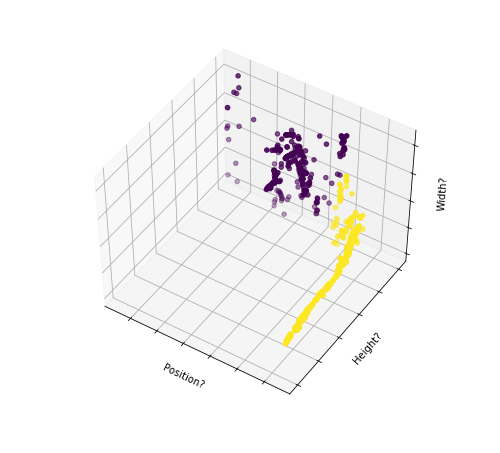

In [72]:
fignum = 1
fig = plt.figure(fignum, figsize=(7, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=50, azim=123)
cluster
labels = cluster.labels_

ax.scatter(all_points[:, 0], all_points[:, 1], all_points[:, 2],
             c=labels.astype(np.float))

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Position?')
ax.set_ylabel('Height?')
ax.set_zlabel('Width?')
ax.dist = 12

In [76]:
peak1_list = []
peak2_list = []
peak3_list = []

for i in range(1500):
    peak = cluster.predict([corrected_output.iloc[i,:-1]])
    signal = corrected_output.iloc[i][1]
    if ( peak == 0 and (signal >= 0.001 or signal <= -0.001)):
        peak1_list.append(corrected_output.iloc[i])
    elif ( peak == 1 and (signal >= 0.001 or signal <= -0.001)):
        peak2_list.append(corrected_output.iloc[i])
    elif ( peak == 2 and (signal >= 0.001 or signal <= -0.001)):
        peak3_list.append(corrected_output.iloc[i])
    else:
        pass

In [77]:
peak1_unfilt = pd.DataFrame(peak1_list, columns=['Position', 'Height', 'Width', 'Time'])
peak1 = peak1_unfilt.drop_duplicates(subset='Time')

peak2_unfilt = pd.DataFrame(peak2_list, columns=['Position', 'Height', 'Width', 'Time'])
peak2 = peak2_unfilt.drop_duplicates(subset='Time')

peak3_unfilt = pd.DataFrame(peak3_list, columns=['Position', 'Height', 'Width', 'Time'])
peak3 = peak3_unfilt.drop_duplicates(subset='Time')

In [78]:
peak1.describe()

,Position,Height,Width,Time
count,310.000000,310.000000,310.000000,310.000000
mean,357.896774,0.087878,236.990323,169.841935
std,68.512695,0.070756,85.969043,111.604962
min,195.000000,0.004731,19.000000,0.000000
25%,348.750000,0.033202,168.250000,77.250000
50%,362.500000,0.061039,232.000000,154.500000
75%,377.000000,0.118023,291.000000,256.750000
max,654.000000,0.302165,422.000000,495.000000


In [79]:
peak2.describe()

,Position,Height,Width,Time
count,0,0,0,0
unique,0,0,0,0


In [80]:
peak3.describe()

,Position,Height,Width,Time
count,500.000000,500.000000,500.000000,500.000000
mean,101.100000,0.370619,122.620000,249.500000
std,32.284277,0.258692,13.405185,144.481833
min,51.000000,0.083452,76.000000,0.000000
25%,74.000000,0.151349,115.000000,124.750000
50%,96.000000,0.274295,121.000000,249.500000
75%,122.000000,0.557007,129.000000,374.250000
max,210.000000,1.001380,225.000000,499.000000


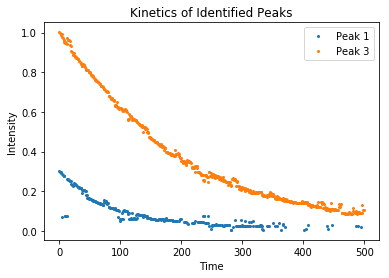

In [81]:
plt.plot(peak1['Time'], peak1['Height'], 'o', markersize = 2, label = 'Peak 1')
plt.plot(peak3['Time'], peak3['Height'], 'o', markersize = 2, label = 'Peak 3')
plt.title('Kinetics of Identified Peaks')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

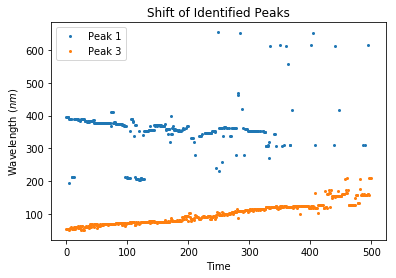

In [82]:
plt.plot(peak1['Time'], peak1['Position'], 'o', markersize = 2, label = 'Peak 1')
plt.plot(peak3['Time'], peak3['Position'], 'o', markersize = 2, label = 'Peak 3')
plt.title('Shift of Identified Peaks')
plt.xlabel('Time')
plt.ylabel('Wavelength $(nm)$')
plt.legend()
plt.show()

In [83]:
def singleexpfunc(t, params):
    exp_array = params[0] *np.exp((-1.0/params[1]) * t)

    return exp_array

def fit_single_exp_diffev(t, data, bounds):
    time_array = t
    data_array = data
    def fit(params):
        decaymodel = singleexpfunc(time_array, params[:])
        cost = np.sum(((data_array - decaymodel) ** 2.0))
        return cost
    bestfit = differential_evolution(fit, bounds = bounds, polish = True)
    bestfit_params = bestfit.x
    def bestfit_decay(params):
        decaymodel = singleexpfunc(time_array, params[:])
        return decaymodel    
    bestfit_model = bestfit_decay(bestfit_params)   
    
    ss_res = np.sum((data_array - bestfit_model) ** 2.0)
    ss_tot = np.sum((data_array - np.mean(data_array)) ** 2.0)
    rsquare = 1 - (ss_res / ss_tot)
    #print '--Single exponential best fit parameters--'
    print ('a = %.5f  \ntau = %.5f ps  \nR-square = %.5f' %(bestfit_params[0], bestfit_params[1], rsquare))
    plt.figure()
    plt.ylabel('-$\Delta$T/T')   
    plt.xlabel('Time (ps)')

    plt.plot(time_array, data_array, 'o', color = 'b', label = 'Data')
    plt.plot(time_array, bestfit_model, color = 'r', label = 'Monoexponential')
#    plt.text(10, 0.002, 'tau = 3ps', fontsize = 14)

    plt.legend(loc = 'best')

    plt.figure()
    #plt.xlim(0, 200)
    plt.ylabel('-$\Delta$T/T')   
    plt.xlabel('Time (ps)')
    plt.xscale('log')    
    plt.plot(time_array, data_array, 'o', color = 'b', label = 'Data')
    plt.plot(time_array, bestfit_model, color = 'r', label = 'single exp fit')
    plt.legend(loc = 'best')

    return bestfit_params, bestfit_model, data_array, time_array

a = 0.25488  
tau = 115.31177 ps  
R-square = 0.85685


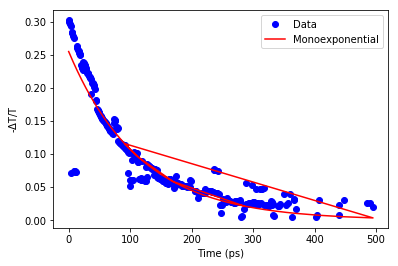

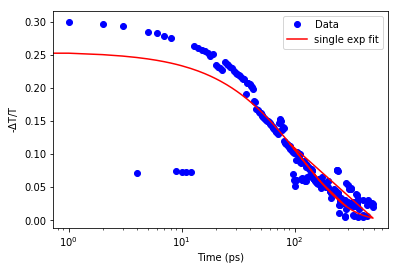

In [85]:
"""load TA data"""
#experiment name
experiment = ''

times, decaytrace = peak1['Time'], peak1['Height']



"""exponential decay parameters"""
a1_bounds = (0, 2)
tau1_bounds = (0, 1000)
beta1_bounds = (0,1)

sing_expdec_bounds = [a1_bounds, tau1_bounds]
exp_stret_bounds = [a1_bounds, tau1_bounds, beta1_bounds]



"""fit data"""
fit_data_sing_expdec = fit_single_exp_diffev(times, decaytrace, sing_expdec_bounds)

#fit_data_exp_stretch = fit_exp_stretch_diffev(times, decaytrace, exp_stret_bounds)

a = 1.01900  
tau = 196.65891 ps  
R-square = 0.99740


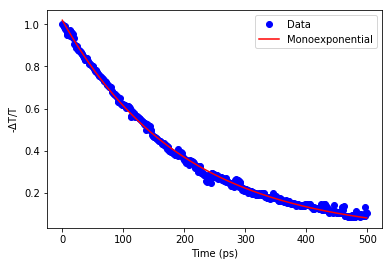

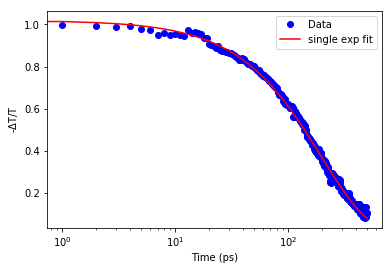

In [86]:
"""load TA data"""
#experiment name
experiment = ''

times, decaytrace = peak3['Time'], peak3['Height']



"""exponential decay parameters"""
a1_bounds = (0, 2)
tau1_bounds = (0, 10000)
beta1_bounds = (0,1)

sing_expdec_bounds = [a1_bounds, tau1_bounds]
exp_stret_bounds = [a1_bounds, tau1_bounds, beta1_bounds]



"""fit data"""
fit_data_sing_expdec = fit_single_exp_diffev(times, decaytrace, sing_expdec_bounds)

#fit_data_exp_stretch = fit_exp_stretch_diffev(times, decaytrace, exp_stret_bounds)